# Ensemble

This workbook focuses on the ensemble methods. First, we review the decision tree, which is the first machine learning model we learn. It plays the role of a base model. There are three ensemble methods that improve the performance of the decision tree.

This dataset is provided in Google colab: visit this notebook by colab shared link, or upload the notebook to Google Drive, and right click `Open with | Connect more apps | Google Colaboratory`. To begin with, we load the California house price dataset, training set and testing set repectively.

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

In [153]:
housing_train = pd.read_csv("./sample_data/california_housing_train.csv")
housing_test = pd.read_csv("./sample_data/california_housing_test.csv")

## Data profiling

We preview the dataset to know about the number of features and observations, type of features, missing values and so on.

In [ ]:
housing_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


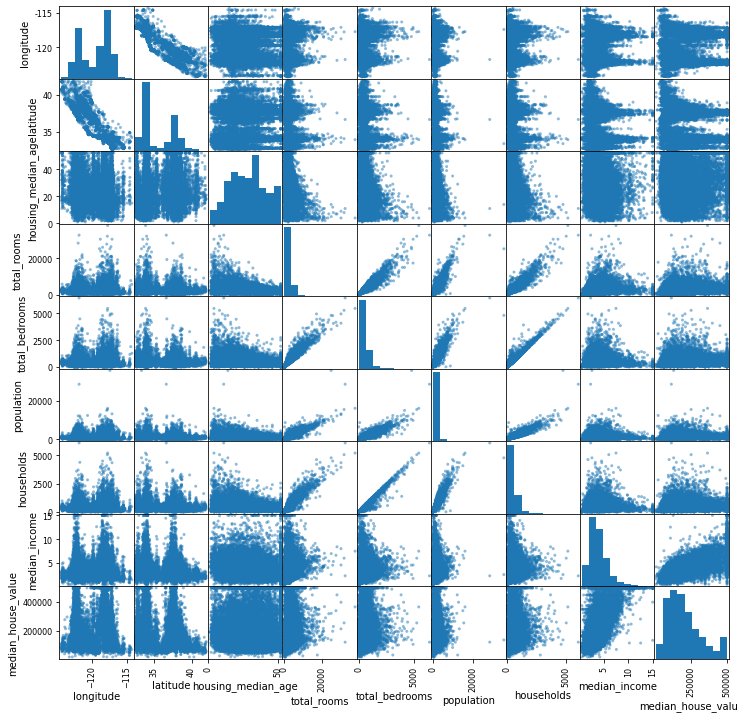

In [ ]:
pd.plotting.scatter_matrix(housing_train, figsize=(12, 12))
plt.show()

Obviously, there're some features highly correlated, for example `total_rooms, total_bedrooms, population, households` form multicollinearity. Also, there is no independent variables highly correlated with the dependent variable, so there is no way to predict the dependent variable by a single indicator.

Calculate the number of missing values.

In [ ]:
missing_values_dict = dict(zip(housing_train.columns, housing_train.isna().mean()))
missing_values_dict

{'longitude': 0.0,
 'latitude': 0.0,
 'housing_median_age': 0.0,
 'total_rooms': 0.0,
 'total_bedrooms': 0.0,
 'population': 0.0,
 'households': 0.0,
 'median_income': 0.0,
 'median_house_value': 0.0}

There is no missing values in the dataset.

The variable `median_house_value` is the response variable, the others are independent variables. We don't have information about whether the house is located in down town, so we remove `longitude, latitude`.

In [ ]:
x_train = housing_train[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                         'households', 'median_income']]
y_train = housing_train['median_house_value']
x_test = housing_test[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                       'households', 'median_income']]
y_test = housing_test['median_house_value']

## Decision tree

As a baseline, we build a decision tree model on the training set with default hyper-parameters, and evaluate the performance on the testing set.

In [ ]:
def evaluate(mdl):
  y_train_hat = mdl.predict(x_train)
  print('Training set MAPE:', mean_absolute_percentage_error(y_train, y_train_hat))
  y_test_hat = mdl.predict(x_test)
  print('Testing set MAPE:', mean_absolute_percentage_error(y_test, y_test_hat))

In [ ]:
dt = DecisionTreeRegressor(random_state=29458)
dt.fit(x_train, y_train)
evaluate(dt)

Training set MAPE: 0.0
Testing set MAPE: 0.3976702834001726


Obviously, it's overfitted. 
- How many nodes are there in the tree?
- How many observations are there in the dataset?
- What is the max depth?

First, use the function to count leave nodes and max depth. [Reference](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#tree-structure)

In [ ]:
def count_leave_depth(clf):
  n_nodes = clf.tree_.node_count
  children_left = clf.tree_.children_left
  children_right = clf.tree_.children_right
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
  is_leaves = np.zeros(shape=n_nodes, dtype=bool)
  stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
  while len(stack) > 0:
      # `pop` ensures each node is only visited once
      node_id, depth = stack.pop()
      node_depth[node_id] = depth

      # If the left and right child of a node is not the same we have a split
      # node
      is_split_node = children_left[node_id] != children_right[node_id]
      # If a split node, append left and right children and depth to `stack`
      # so we can loop through them
      if is_split_node:
          stack.append((children_left[node_id], depth + 1))
          stack.append((children_right[node_id], depth + 1))
      else:
          is_leaves[node_id] = True
  return is_leaves.sum(), node_depth.max()

In [ ]:
n_leaves, max_depth = count_leave_depth(dt)
print(n_leaves, "nodes.")
print(y_train.unique().shape[0], "unique observations.")
print(y_train.shape[0], "observations.")
print("Max depth:", max_depth)

16397 nodes.
3694 unique observations.
17000 observations.
Max depth: 38


The number of nodes are even more than unique values, close to the number of all observations.

It means this decision tree "remember" the training set instead of figuring out meaningful rules.

*Do not rely on the default settings.*

To address the problem, we could visualize this tree.

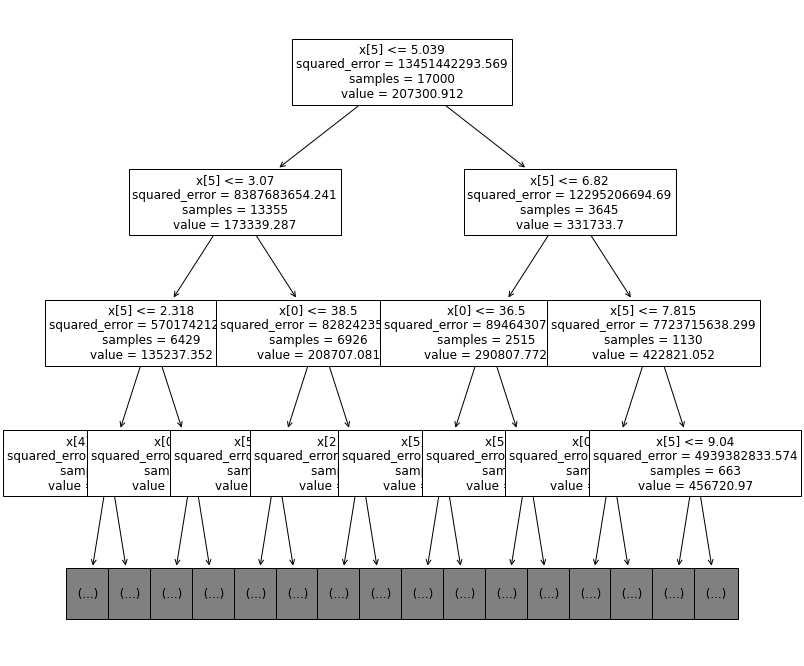

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
# the tree is too deep, we trim it to 3 layers
plot_tree(dt, max_depth=3, ax=ax, fontsize=12)
plt.show()

We could search for a best `max_depth`.

*This chunk takes a long time to run.*

In [ ]:
k_fold = KFold(shuffle=True, random_state=20493)
dt_auto_depth = GridSearchCV(
    DecisionTreeRegressor(random_state=29458),
    {'max_depth': range(1, max_depth + 1)},
    cv=k_fold.split(x_train), refit=True
)
dt_auto_depth.fit(x_train, y_train)
evaluate(dt_auto_depth)
print("Best hyper-parameter:", dt_auto_depth.best_params_)

Training set MAPE: 0.3275265817343314
Testing set MAPE: 0.33799869484431727
Best hyper-parameter: {'max_depth': 7}


We can visualize the best tree.

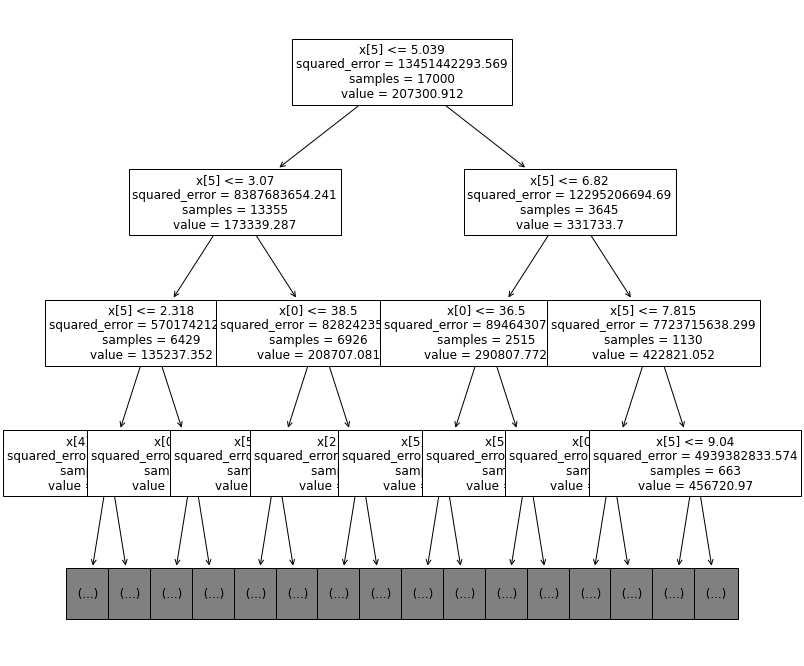

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(dt_auto_depth.best_estimator_, max_depth=3, ax=ax, fontsize=12)
plt.show()

The training and testing loss become similar, but there is no much improvement. We can also use post-pruning method, but it's not the focus of this workbook. We consider using some ensemble methods.

## Bootstraping

Random forest is a kind of bootstrap method. For each tree, it draws a range of features and a range of observations.

In [ ]:
# default number of estimators is 100
rf = RandomForestRegressor(max_features=3, random_state=29458)
rf.fit(x_train, y_train)
evaluate(rf)

Training set MAPE: 0.10862773168435857
Testing set MAPE: 0.29168771216899986


Notice we don't assign a `max_ddepth` here, because the bootstrap method itself has the ability to prevent overfitting.

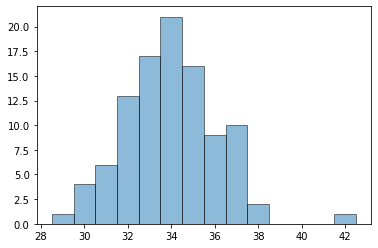

In [ ]:
nodes = np.zeros(rf.n_estimators)
depth = np.zeros(rf.n_estimators)
for i in range(rf.n_estimators):
  nodes[i], depth[i] = count_leave_depth(rf.estimators_[i])
fig, ax = plt.subplots()
ax.hist(depth, range=(depth.min()-0.5, depth.max()+0.5), 
        bins=int(depth.max() - depth.min() + 1), alpha=0.5, edgecolor='k')
plt.show()

We can plot some of the trees in the random forest.

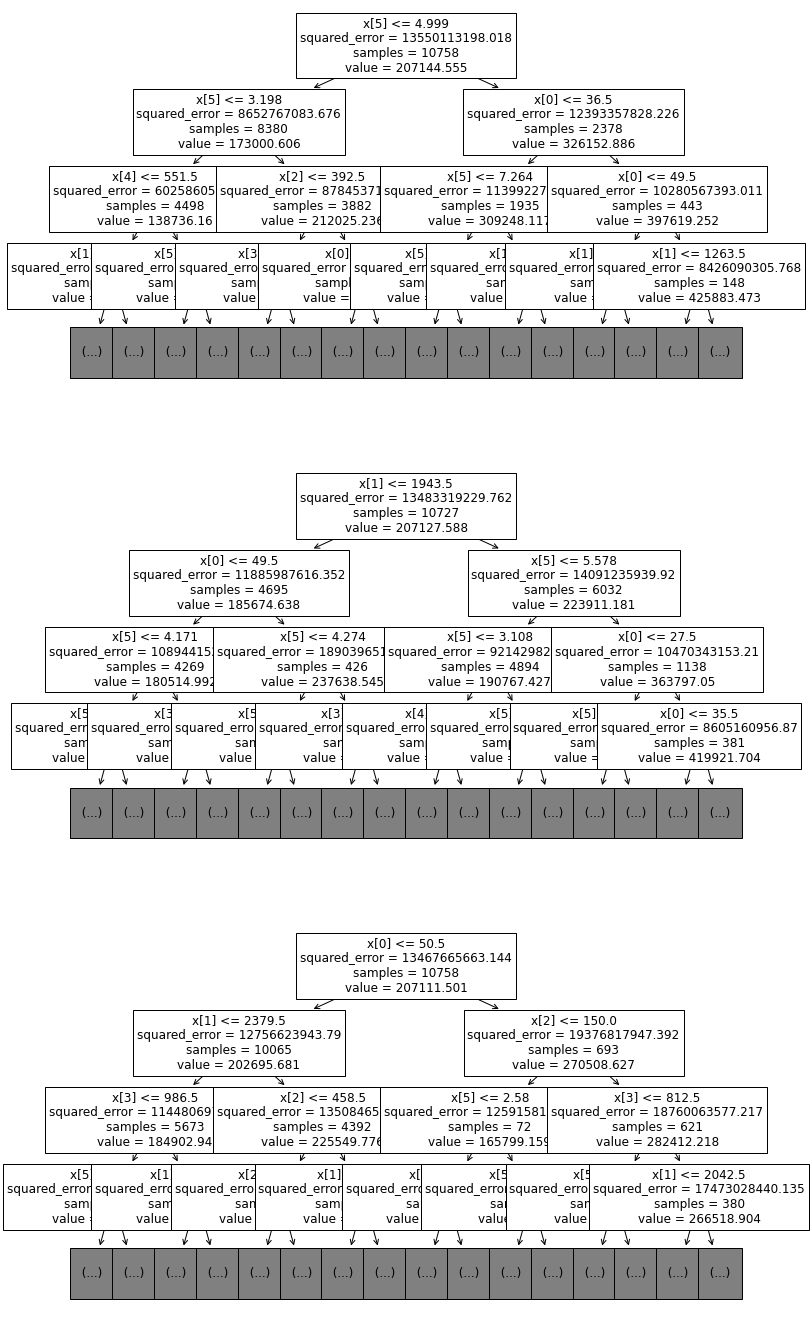

In [ ]:
rs = np.random.RandomState(seed=89032)
random_select_trees = rs.choice(np.arange(rf.n_estimators), size=3)
fig, axes = plt.subplots(figsize=(12, 24), nrows=3)
for i in range(3):
  plot_tree(rf.estimators_[random_select_trees[i]], max_depth=3, ax=axes[i], fontsize=12)
plt.show()

We find each tree in the dataset varies: they use different splitting rules and have different thresholds.

## Bagging

Bagging is an ensemble algorithm that fits multiple models on different subsets of a training dataset, then combines the predictions from all models. Random forest is an extension of bagging that also randomly selects subsets of features used in each data sample.
[Reference](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)



In [ ]:
bagging = BaggingRegressor(n_estimators=100, random_state=29458)
bagging.fit(x_train, y_train)
evaluate(bagging)

Training set MAPE: 0.10924237755049732
Testing set MAPE: 0.29448940157947795


With default setting, the testing MAPE is better than decision tree, and is similar to the random forest.

In [ ]:
bagging = BaggingRegressor(n_estimators=100, max_features=3, random_state=204935)
bagging.fit(x_train, y_train)
evaluate(bagging)

Training set MAPE: 0.15765524395213765
Testing set MAPE: 0.40843847914128417


However, when setting `max_features`, which **seems to** follows the same standard as the random forest, the performance goes worse.

Why?

Notice the `max_features` in random forest says **"when looking for the best split"**. It uses three features in each split, but more than 3 features may appear in the whole tree.

However, the bagging model allocates only 3 features for each tree, and the features are the same for each tree.

Actually, although the documentation says it "drawn" `max_features` features, but it just uses the first 3 provided features (after I tried many different random states). We can visualize and prove it.

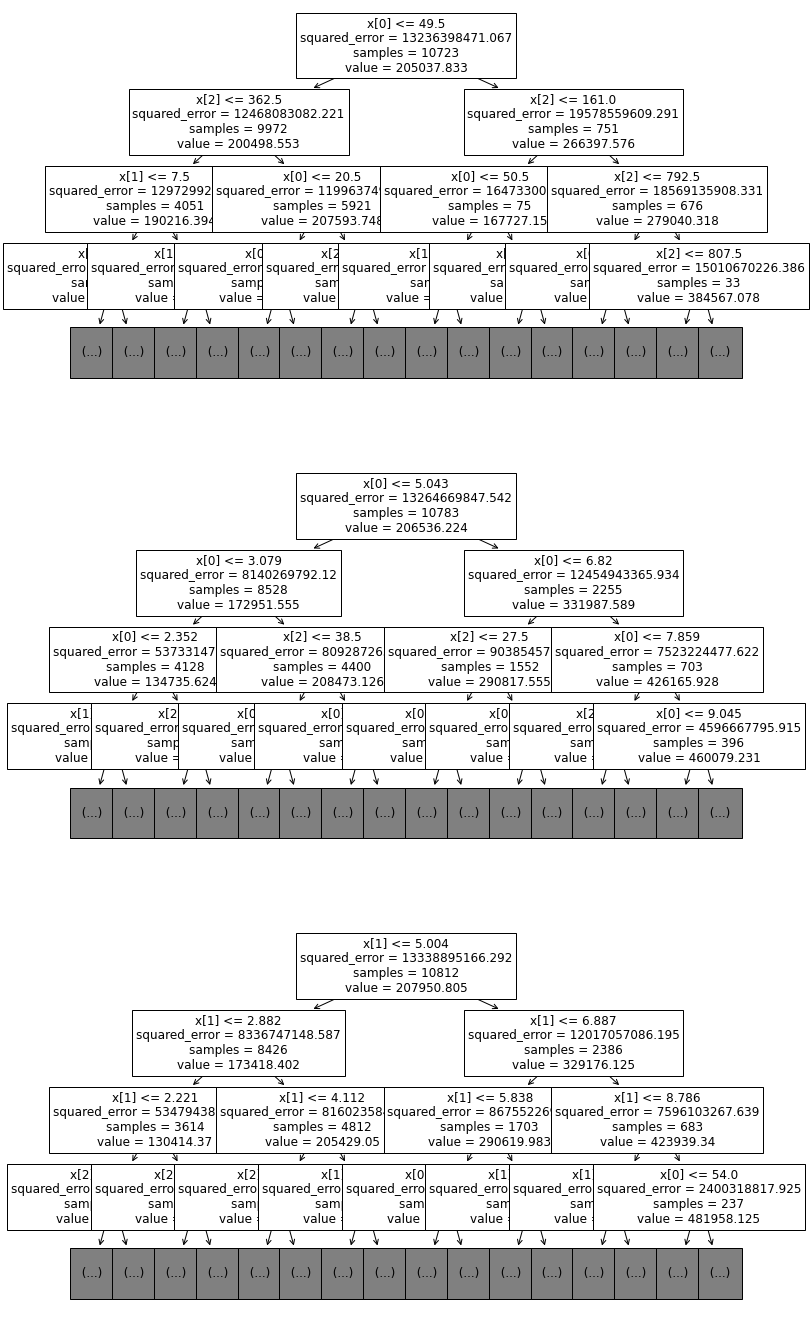

In [ ]:
rs = np.random.RandomState(seed=102348)
fig, axes = plt.subplots(figsize=(12, 24), nrows=3)
for i in range(3):
  plot_tree(bagging.estimators_[random_select_trees[i]], max_depth=3, ax=axes[i], fontsize=12)
plt.show()

If we use `bootstrap_features` argument, we draw the features with replacement, which is also different from the random forest model.

*Do not rely on this function since it may have problems.*

## Boosting

XGBoost regressor fits each tree on the residuals of the previous tree.

In [ ]:
xgb = XGBRegressor(n_estimators=100, random_state=29458)
xgb.fit(x_train, y_train)
evaluate(xgb)

Training set MAPE: 0.20878051405513928
Testing set MAPE: 0.29220417557681655


The training MAPE is also similar to the random forest.

There is no API to extract an individual tree in XGBoost.

## Stacking

Stacking makes use of different models and fit the final result with a "final regressor". The stacked base models can be different.

In [165]:
stacking = StackingRegressor(
    [('dt', DecisionTreeRegressor(max_depth=7, random_state=912935)),
     ('SVR', LinearSVR(max_iter=1000, C=0.01))],
)
stacking.fit(x_train, y_train)
evaluate(stacking)

Training set MAPE: 0.4079622450264587
Testing set MAPE: 0.4206631268404407


We haven't learn the support vector machine now. We use this example just to show that stacking model has the ability to stack different models.

Because we haven't normalize our dataset (pre-processing) in this workbook, so the result of the support vector machine won't be good. To address this issue, we can output the prediction of each base model.

In [171]:
evaluate(stacking.estimators_[0])

Training set MAPE: 0.3275265817343314
Testing set MAPE: 0.33799869484431727


In [172]:
evaluate(stacking.estimators_[1])

Training set MAPE: 0.5121173254190065
Testing set MAPE: 0.48988101943999335


The performance of stacking tends to be the average of all base models. In majority of applications, it cannot improve the accuracy, but can increase the stability or robustness.

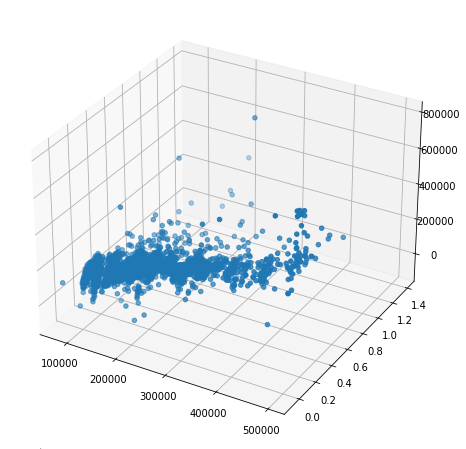

In [179]:
stacking_rf_hat = stacking.estimators_[0].predict(x_test)
stacking_svr_hat = stacking.estimators_[1].predict(x_test)
lr = LinearRegression()
lr.fit(x_train, y_train)
stacking_lr_hat = lr.predict(x_test)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.scatter(stacking_rf_hat, stacking_svr_hat, stacking_lr_hat)
plt.show()

We find the final regressor generally fits a straight line based on the prediction of base models.